In [29]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import scipy.stats as sps

from mpl_toolkits.axes_grid1 import make_axes_locatable

from datetime import datetime

from itertools import repeat,chain,accumulate


In [30]:
def convert_to_unix_timestamp(date_str):
    format_str = '%Y-%m-%d %H:%M:%S'
    dt = datetime.strptime(date_str, format_str)
    return int(dt.timestamp())-1511172900+16*3600+55*60 # 00 и 24 соотв

df = pd.read_csv("year_data.csv", index_col=0)
df["dt_int"] = df["dt"].apply(convert_to_unix_timestamp)

# Filter rows where 'usdk' column equals 30
usdk30 = df[df['usdk'] == 30]
usdk31 = df[df['usdk'] == 31]

# Further filter usdk30 based on 'zone' values
usdk30_3 = usdk30[usdk30['zone'] == 3]
usdk30_4 = usdk30[usdk30['zone'] == 4]
usdk30_5 = usdk30[usdk30['zone'] == 5]
usdk31_7 = usdk31[usdk31['zone'] == 7]

In [31]:

def Create_stats_df(df):
    """     usdk_time = [] --- временные интервалы между прибытиями машин
            usdk_stat = [] --- число прибывающих в интервалы машин
    """
    usdk_statint = df['stat'][1:].to_numpy()   - df['stat'][:-1].to_numpy() 
    usdk_time    = df['dt_int'][1:].to_numpy()
    
    
    #%%%%%%%%%%%%%%%%%%%%%
    new_df_stat = []
    new_df_time = []
    n=0
    for car in usdk_statint:
        if car:
            new_df_stat.append(list(repeat(usdk_statint[n], car)))
            new_df_time.append(list(repeat(usdk_time[n], car)))
        n+=1

    usdk_stat = list(chain.from_iterable(new_df_stat))
    usdk_time = list(chain.from_iterable(new_df_time))
    
    return usdk_stat, usdk_time
    
    

In [32]:
def Make_day_time_partiotion(usdk_stat, usdk_time):
    data = []
    data1 = []
    time1 = []
    n = 1
    for d in range(len(usdk_time)):
        if usdk_time[d] >  3600*24*n: 
            while usdk_time[d] >  3600*24*n : n+=1
            new_data = {'time': np.array(time1), 'stat': np.array(data1)}
            data.append(new_data)
            
            data1 = []
            time1 = []
            
        data1.append(usdk_stat[d])  
        time1.append(usdk_time[d]%(3600*24*(n)) - (3600*24*(n-1)))
        
    return data

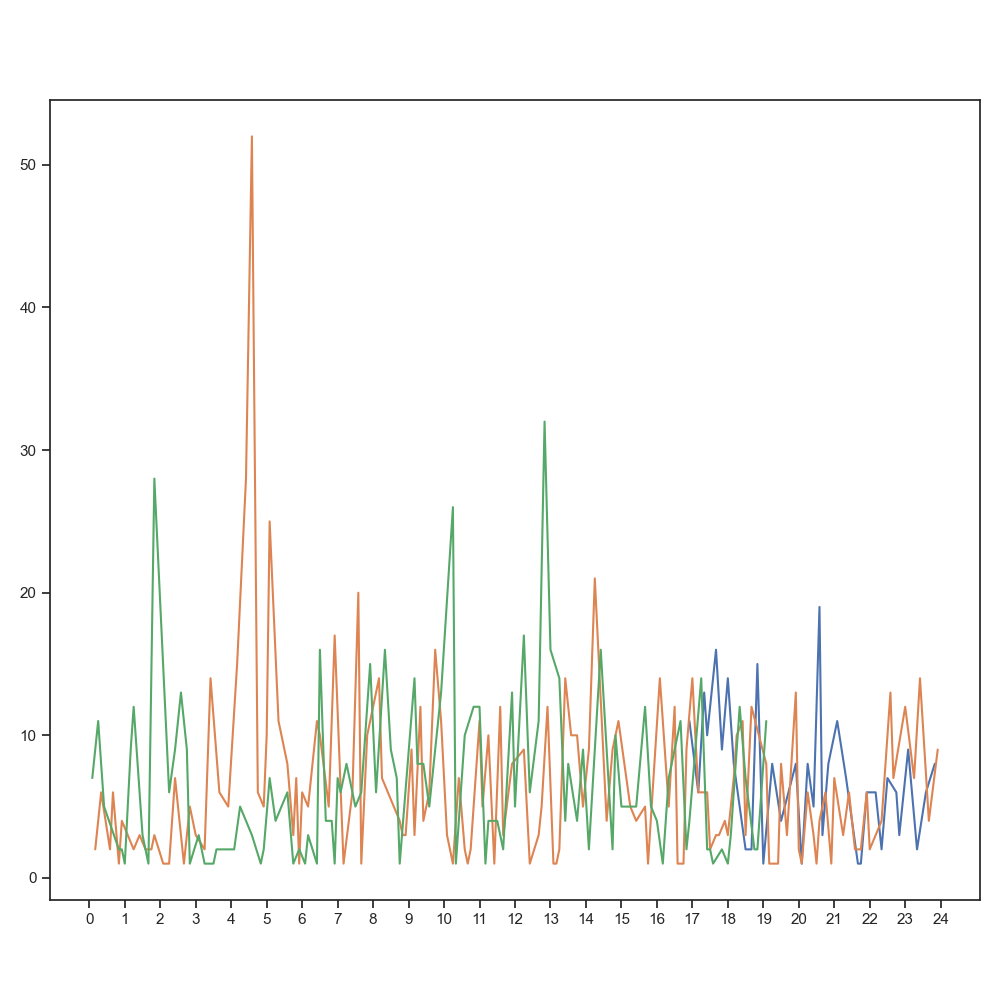

In [33]:


# ПРИМЕР ВЫГРУЗКИ СУТОЧНЫХ ДАННЫХ



fig = plt.figure(figsize= (10,10))

margins = {                                                                          
    "left"   : 0.05,
    "bottom" : 0.1,
    "right"  : 0.98,
    "top"    : 0.9  
}
fig.subplots_adjust(**margins)  

hours_tiks = np.array(list(range(25)))
hours_tiks_labels = map(str,hours_tiks)


ax = fig.add_subplot( 1,1,1)
ax.set_xticks(hours_tiks*3600, hours_tiks_labels)


usdk_stat, usdk_time = Create_stats_df(usdk30_3)
data = Make_day_time_partiotion(usdk_stat, usdk_time)

days = 3
for d in data[:days]:
    x = d["stat"]
    y = d["time"]
    ax.plot(y,x)

In [34]:
def Cut_day_time__period(data, hour, period):
    data_accum = np.array([])
    time = hour*3600
    for d in data:
        y = np.where( (d["time"]>=time) & (d["time"]<=time+period*3600))
        x = d["stat"][y]
        data_accum =  np.append(data_accum, x)

    data_accum = np.array(sorted(data_accum))
    return data_accum

(array([0.04438166, 0.06674108, 0.05963676, 0.03803311, 0.0196735 ,
        0.01241803, 0.00579043, 0.002465  , 0.0003837 , 0.00047672]),
 array([ 1.,  5.,  9., 13., 17., 21., 25., 29., 33., 37., 41.]),
 <BarContainer object of 10 artists>)

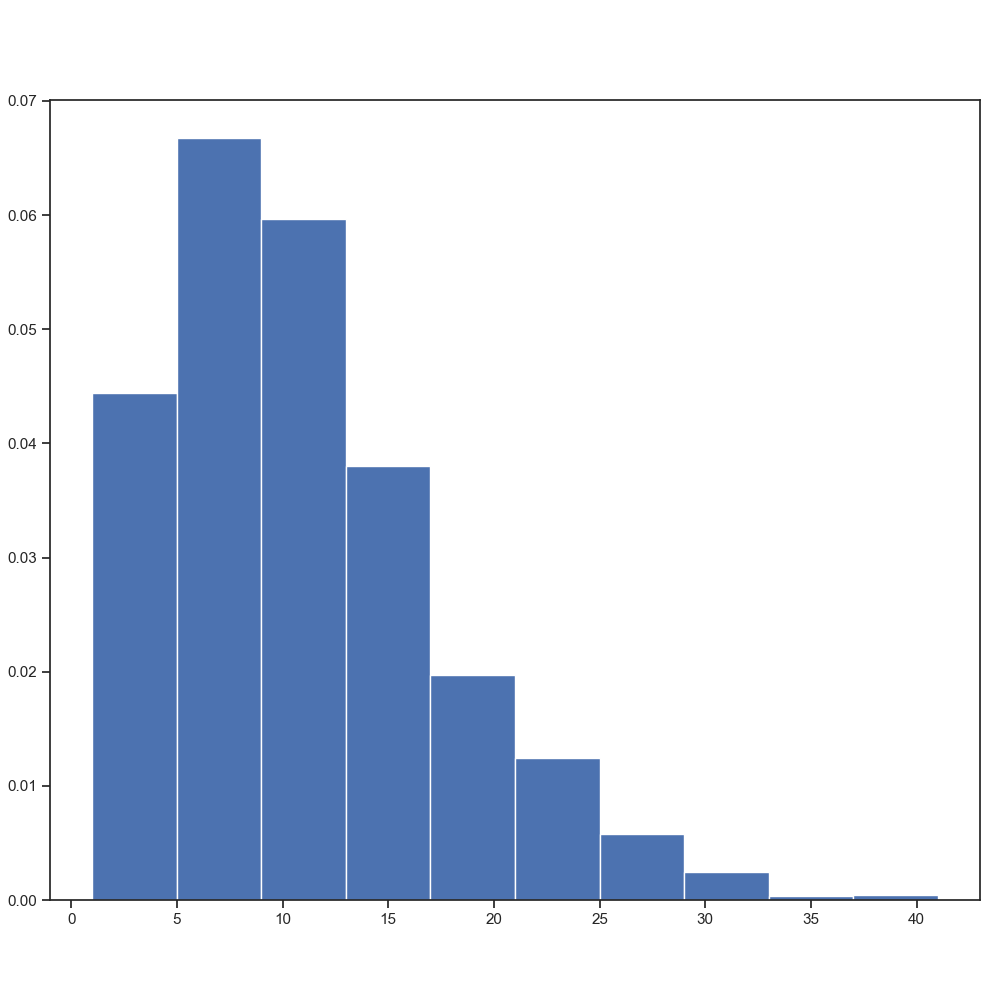

In [35]:
fig = plt.figure(figsize= (10,10))

margins = {                                                                          
    "left"   : 0.05,
    "bottom" : 0.1,
    "right"  : 0.98,
    "top"    : 0.9  
}
fig.subplots_adjust(**margins)  

hours_tiks = np.array(list(range(25)))
hours_tiks_labels = map(str,hours_tiks)


ax = fig.add_subplot( 1,1,1)
# ax.set_xticks(hours_tiks*3600, hours_tiks_labels)
data_accum = Cut_day_time__period(data, 10,4)

ax.hist(data_accum, density = True)

In [36]:
def make_kernel(data, kernel, h = 0):
    size = len(data)
    if not(h): h = hopt = pow(2.4*np.exp(4)/size, 0.2)
    
    g = lambda x_: sum([kernel((x_-x)/(h)) for x in data])/size/h

    x = np.arange(min(data), max(data), h)
    id = np.argsort(x)
    
    y = np.array([g(x_) for x_ in id])
        
        
    return x[id],y

ker_list = [
    lambda x: pow(2*np.pi,-0.5)*np.exp(-0.5*x*x),
    lambda x: 0.5*np.abs(x),
    lambda x:1 - np.abs(x),
    lambda x:0.75*(1-x*x),
    lambda x:(1+2*np.abs(x))*pow(1-np.abs(x),2),
    lambda x:1/np.pi*np.sqrt(1-x*x),
    lambda x:1/np.sqrt(2*np.pi)*np.exp(-0.5*x*x),
    lambda x:0.5*np.exp(-np.abs(x)),
    lambda x: 1/(np.pi*(1+x*x)),
    lambda x: 1/(np.exp(x)+2+np.exp(-x))
]

bins_list = lambda size:[
    int(1 + np.log2(size)),
    4*int(pow(0.75*pow(size - 1, 2), 0.2)),
    int(5*np.log10(size))
]

def draw_hist(data,ax, kernel = 0):
    #draw hist
    for bins in bins_list(len(data)):
        h, bins, pathces = ax.hist(data, bins=bins, color=BLUE, density=True)
        ax.hist(data, bins=bins, color=BLUE, density=True)
        #ax.plot(bins[:-1],h)
    # draw kernel hist
    
    x, y = make_kernel(data, ker_list[kernel])
    ax.plot(x, y, label = "ядерная оценка плотности")

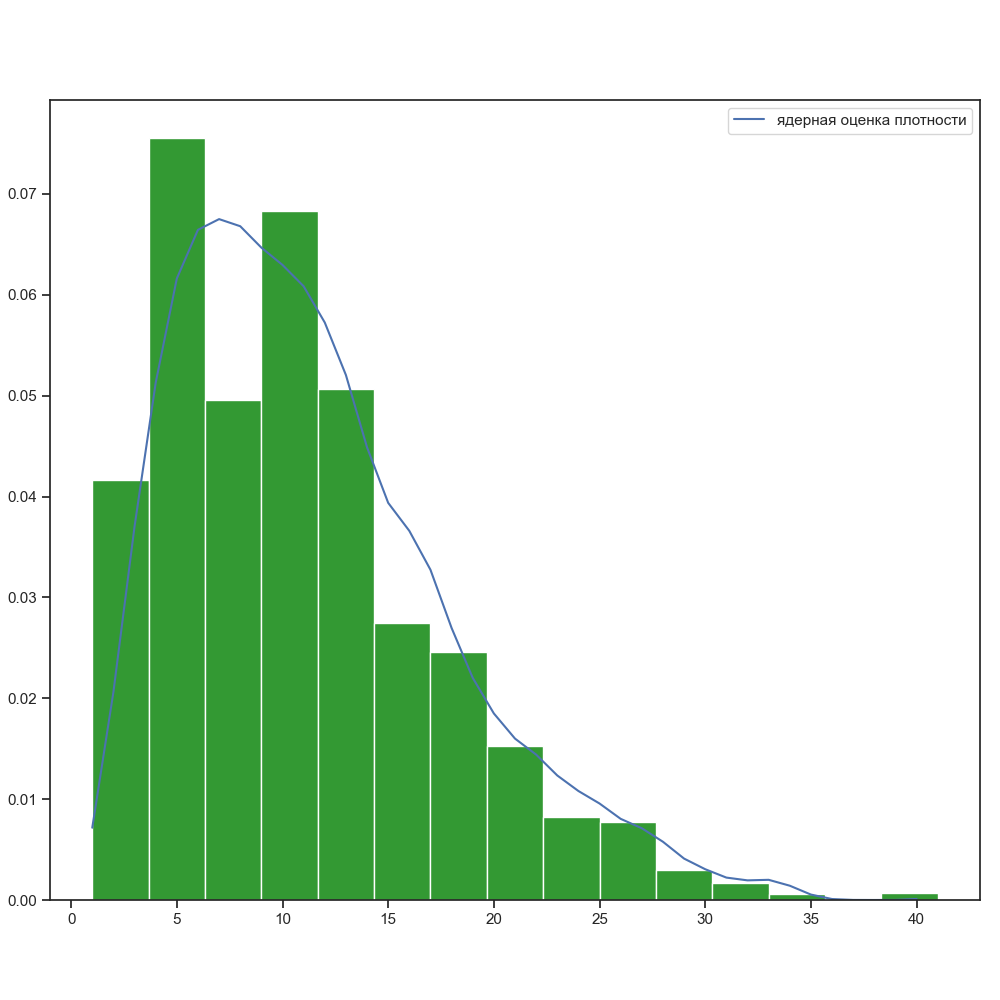

In [37]:
fig = plt.figure(figsize= (10,10))

margins = {                                                                          
    "left"   : 0.05,
    "bottom" : 0.1,
    "right"  : 0.98,
    "top"    : 0.9  
}
fig.subplots_adjust(**margins)  

ax = fig.add_subplot( 1,1,1)
size = len(data_accum)


h, bins, pathces = ax.hist(data_accum, bins =  int(1 + np.log2(size)), color=(0,0.5,0,.8), density=True)

x, y = make_kernel(data_accum, kernel = lambda x: pow(2*np.pi,-0.5)*np.exp(-0.5*x*x) , h= 1)
ax.plot(x, y, label = "ядерная оценка плотности")

ax.legend()

In [38]:
exponential_data = data_accum
gaussian_data = sps.norm(loc = 45, scale = 5).rvs(int(0.3*len(data_accum)))

mixed_data = np.append(exponential_data, gaussian_data)

mixed_data = np.array(sorted(mixed_data))


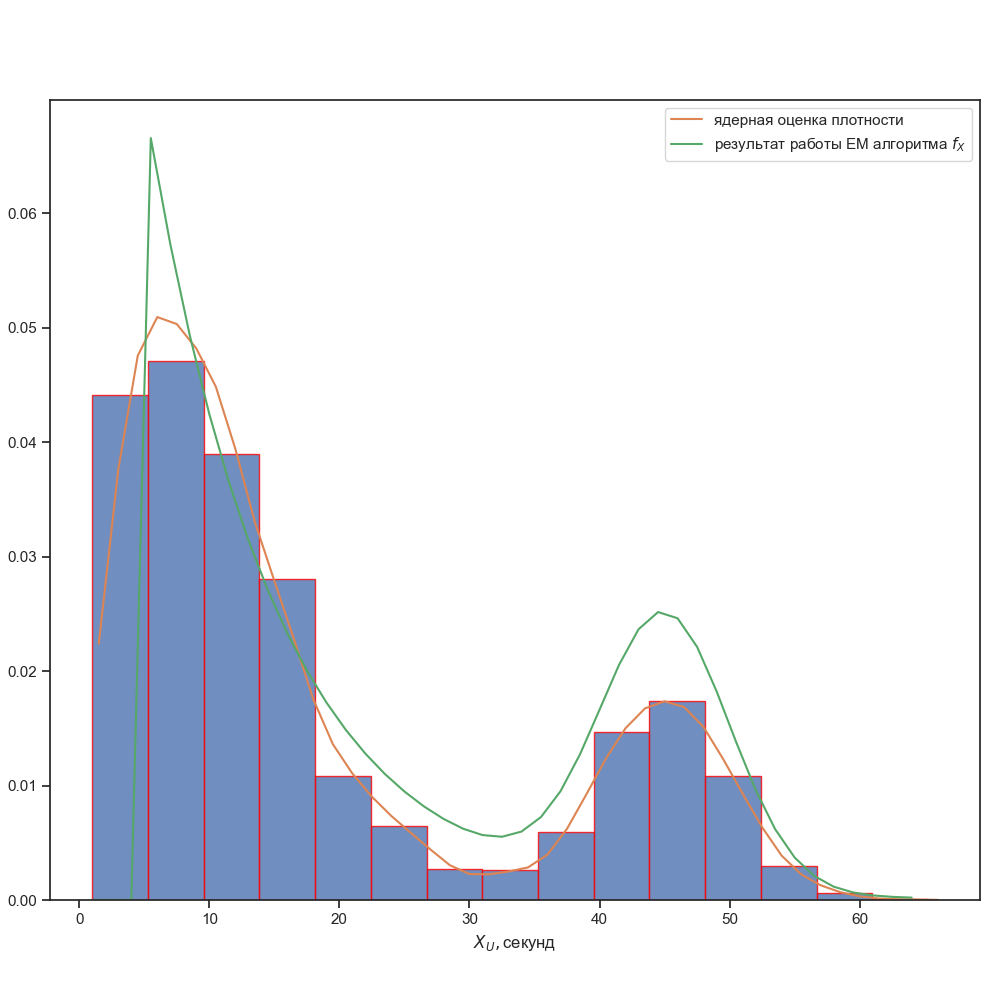

In [40]:
%matplotlib widget
fig = plt.figure(figsize= (10,10))


fig.subplots_adjust(**margins)  

ax = fig.add_subplot( 1,1,1)
size = len(mixed_data)
bins =  int(1 + np.log2(size))
h, bins, pathces = ax.hist(mixed_data, bins=bins, alpha = 0.8, edgecolor=(1,0,0,0.05), density=True)

kernel =  lambda x: pow(2*np.pi,-0.5)*np.exp(-0.5*x*x)

h =  1.5
g = lambda x_: sum([kernel((x_-x)/(h)) for x in mixed_data])/size/h
id = np.argsort(x)

x = np.arange(h, max(mixed_data) + h, h)
y = np.array([g(x_) for x_ in x])

ax.plot(x, y, label = "ядерная оценка плотности")


loc = [5,45]
scale = [10,5]
p = [0.7, 0.3]
f1 = sps.expon(loc  = 5, scale = 10)
f2 = sps.norm(loc = 45, scale = 5)
f = lambda x: f1.pdf(x) *0.7 + f2.pdf(x)*0.3

x = np.arange(mixed_data.min(), mixed_data.max(),h)
ax.plot(x, f(x), label = "результат работы EM алгоритма " + r"$f_X$")


ax.set_xlabel(r"$X_U,$" + "секунд")
ax.set_ylabel(r"$f_X,$")

ax.legend()


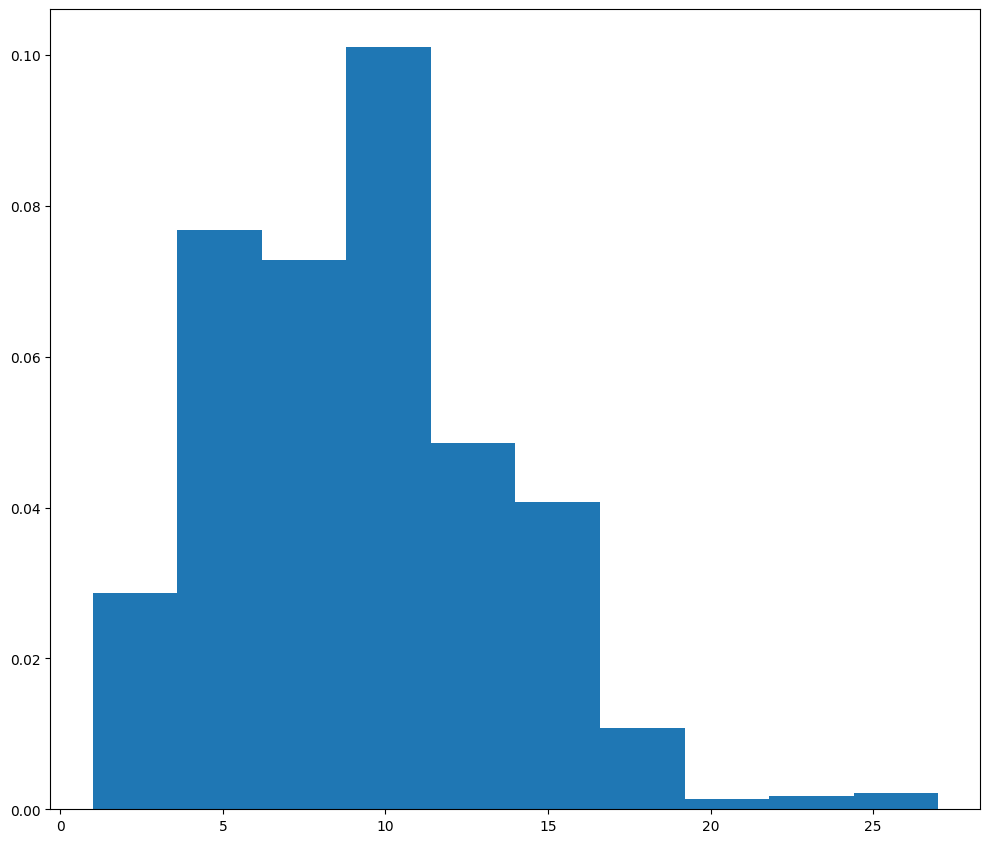

In [ ]:


usdk_stat2, usdk_time2 = Create_stats_df(usdk31_7)
data2 = Make_day_time_partiotion(usdk_stat2, usdk_time2)




fig = plt.figure(figsize= (10,10))

margins = {                                                                          
    "left"   : 0.05,
    "bottom" : 0.1,
    "right"  : 0.98,
    "top"    : 0.9  
}
fig.subplots_adjust(**margins)  

hours_tiks = np.array(list(range(25)))
hours_tiks_labels = map(str,hours_tiks)


ax = fig.add_subplot( 1,1,1)
# ax.set_xticks(hours_tiks*3600, hours_tiks_labels)
data_accum2 = Cut_day_time__period(data2, 10,4)

ax.hist(data_accum2, density = True)









exponential_data2 = data_accum2
gaussian_data2 = sps.norm(loc = 30, scale = 10).rvs(int(0.2*len(data_accum2)))

mixed_data2 = np.append(exponential_data2, gaussian_data2)

mixed_data2 = np.array(sorted(mixed_data2))


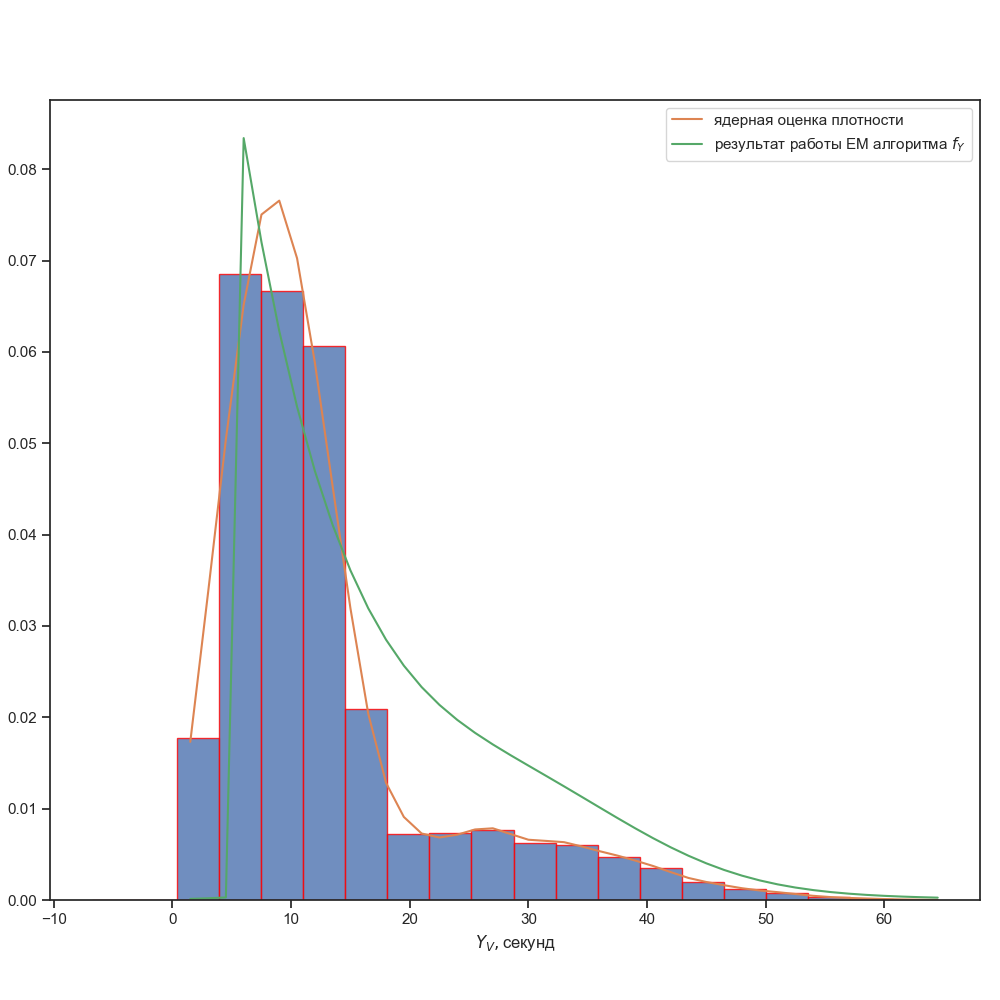

In [43]:

fig = plt.figure(figsize= (10,10))

margins = {                                                                          
    "left"   : 0.05,
    "bottom" : 0.1,
    "right"  : 0.98,
    "top"    : 0.9  
}
fig.subplots_adjust(**margins)  

ax = fig.add_subplot( 1,1,1)
size = len(mixed_data)
bins =  20
h, bins, pathces = ax.hist(mixed_data2, bins=bins, density=True,  alpha = 0.8, edgecolor=(1,0,0,0.05))



kernel =  lambda x: pow(2*np.pi,-0.5)*np.exp(-0.5*x*x)

h =  1.5
g = lambda x_: sum([kernel((x_-x)/(h)) for x in mixed_data2])/size/h
id = np.argsort(x)

x = np.arange(h, max(mixed_data2) + h, h)
y = np.array([g(x_) for x_ in x])

ax.plot(x, y, label = "ядерная оценка плотности")


loc_2 = [6,30]
scale_2 = [10,10]
p_2 = [0.83, 0.18]

f21 = sps.expon(loc  = loc_2[0], scale = scale_2[0])
f22 = sps.norm(loc =  loc_2[1], scale = scale_2[1])
f_2 = lambda x: f21.pdf(x) *p_2[0] + f22.pdf(x)*p_2[1]

ax.plot(x, f_2(x), label = "результат работы EM алгоритма " + r"$f_Y$")


ax.set_xlabel(r"$Y_V,$" + "секунд")
ax.set_ylabel(r"$f_Y,$")


ax.legend()

In [14]:
import seaborn as sns
from matplotlib import cm
sns.set_theme(style="ticks")


def Create_Copula_Marshall_Olkin(alpha, beta):
    @np.vectorize
    def Copula_Marshall_Olkin(u,v):
        return u*v*min(pow(u,-alpha),pow(v,-beta))
    return Copula_Marshall_Olkin

@np.vectorize
def P(x,y):
  return x*y

@np.vectorize
def M(x,y):
  return min(x,y)

In [15]:
def Generate_MO_COPULA(alpha, beta,SIZE = 1000):

    r = np.random.uniform(0,1,SIZE)
    s = np.random.uniform(0,1,SIZE)
    t = np.random.uniform(0,1,SIZE)

    my_max = np.vectorize(lambda x,y: max(x,y))


    U = np.exp((1+alpha/(1-alpha))*my_max(np.log(s), (1-alpha)/alpha*np.log(r)))
    V = np.exp((1+beta/(1-beta))*my_max(np.log(t), (1-beta)/beta*np.log(r)))
    return U,V

def Generate_quantiles(func, p, loc, sigma, U):
    
    func = [sps.expon, sps.norm]
    p = [0.7 , 0.3]
    a = loc
    sigma = scale

    P = list(accumulate(p))
    u = np.random.uniform(0,1,size)
    l = ([1- (u_>P) for u_ in u])
    num = np.argmax(l,axis = 1)
    rvs = np.array([func[n](a[n], sigma[n]).ppf(u_) for n,u_ in zip(num,U)])
    return rvs

In [16]:

alpha = 0.9
beta = 0.2

func = [sps.expon, sps.norm]
func_2 = [sps.expon, sps.norm]

U,V = Generate_MO_COPULA( alpha,beta)
rvs_1 = Generate_quantiles(func, p, loc, scale, U)
rvs_2 = Generate_quantiles(func_2, p_2, loc_2, scale_2, V)

CMO =  Create_Copula_Marshall_Olkin(alpha,beta)
C = CMO(U,V)



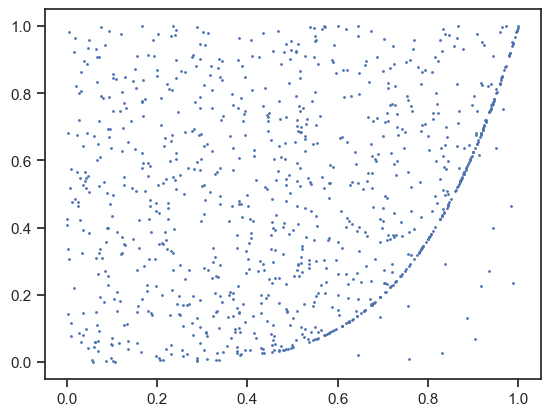

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(U,V,s = 1)


C:\Users\Stationary_PC\AppData\Local\Temp\ipykernel_8760\4227988005.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(U,V,C, s = 1,  cmap = cm.jet, )


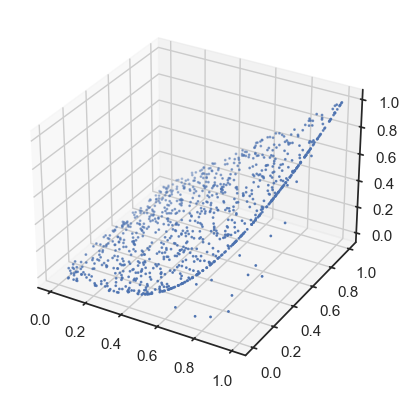

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = "3d")
ax.scatter(U,V,C, s = 1,  cmap = cm.jet, )

In [44]:
def Make_Hist_2d(rvs_1, rvs_2):
    barsx, barsy = 20,20
    H, xed, yed = np.histogram2d(rvs_1, rvs_2, (barsx, barsy),density=True)
    bar_w = (-xed[0]+xed[1]) / 2
    bar_l = (-yed[0]+yed[1]) / 2
    H_ = H

    S = bar_w*bar_l

    XLIM = (0,60)
    YLIM = (0,40)

    # В numpy надо всегда читать документацию (так например Histogram does not follow Cartesian convention )
    H = H.T


    fig = plt.figure(figsize=(12, 8))
    plt.tight_layout(pad=1, w_pad=5, h_pad=1.0)

    ax = fig.add_subplot(221,projection='3d')
    ax.set_xlim(*XLIM)
    ax.set_ylim(*YLIM)
    ax.set_title(r"$f_{XY}^*$")
    ax.set_xlabel(r"$X_u$")
    ax.set_ylabel(r"$Y_v$")

    x = (xed[:-1]+xed[1:])/2

    y = (yed[:-1]+yed[1:])/2

    x_mask = (x>XLIM[0]) & (x<XLIM[1])
    y_mask = (y>YLIM[0]) & (y<YLIM[1])

    x = x[x_mask]
    y = y[y_mask]
    H = H_new = np.array([ h[x_mask] for h in H[y_mask] ])
    x_,y_ = x,y
    x,y = np.meshgrid(x,y)



    ax.bar3d(x.ravel() + bar_w, y.ravel() + bar_l,   0, 2* bar_l, 2* bar_w, H.ravel(),  shade = True, alpha = 0.8, edgecolor=(1,0,0,0.05))

    ax = fig.add_subplot(223,projection='3d')
    ax.set_xlim(*XLIM)
    ax.set_ylim(*YLIM)
    ax.set_title(r"$f_{XY}$")
    ax.set_xlabel(r"$X_u$")
    ax.set_ylabel(r"$Y_v$")


    f = lambda x: f1.pdf(x) *0.7 + f2.pdf(x)*0.3
    F = f
    G = f_2
    CMO = Create_Copula_Marshall_Olkin(alpha, beta)
    C1 = CMO(F(x),G(y))


    ax.plot_trisurf(x.ravel(), y.ravel(),C1.ravel(),  edgecolor=(1,0,0,1))



    ax = fig.add_subplot(222)
    ax.set_xlim(*XLIM)
    ax.set_ylim(*YLIM)
    ax.set_title(r"Уровни")
    ax.set_xlabel(r"$X_u$")
    ax.set_ylabel(r"$Y_v$")
    CS = ax.contour(x, y, H, linewidths = 2)
    ax.clabel(CS,CS.levels)


    ax = fig.add_subplot(224)
    ax.set_xlim(*XLIM)
    ax.set_ylim(*YLIM)
    ax.set_xlabel(r"$X_u$")
    ax.set_ylabel(r"$Y_v$")
    CS = ax.contour(x,y,C1, linewidths = 2)
    ax.clabel(CS,CS.levels)



    plt.show()

    return H,x,y

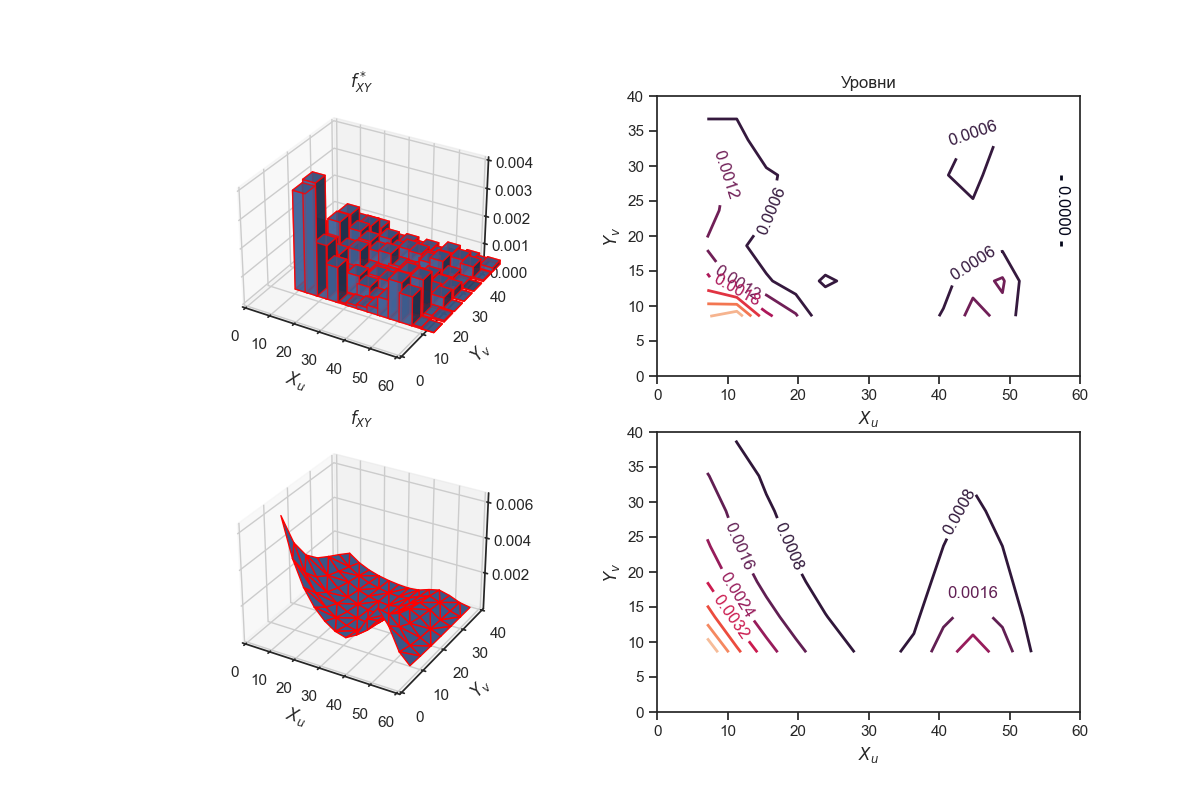

In [45]:
%matplotlib widget
pdf,x,y = Make_Hist_2d(rvs_1, rvs_2 )

In [21]:
def Num_inegrate_density(pdf,x,y):
    S = (x[0,1]-x[0,0])*(y[1,0]-y[0,0])*2*2 #тк эти точки в середине ячеек
    cdf = np.zeros_like(pdf)

    for i in range(pdf.shape[0]):
        for j in range(pdf.shape[1]):
            bufferH= pdf[:i+1, :j+1].ravel()
            buffer = bufferH.sum()* S
            cdf[i, j] += buffer

    # Нормализуем CDF так, чтобы она была от 0 до 1
    #cdf = cdf / cdf[-1, -1]
    return cdf

In [22]:
cdf  = Num_inegrate_density(pdf,x,y)

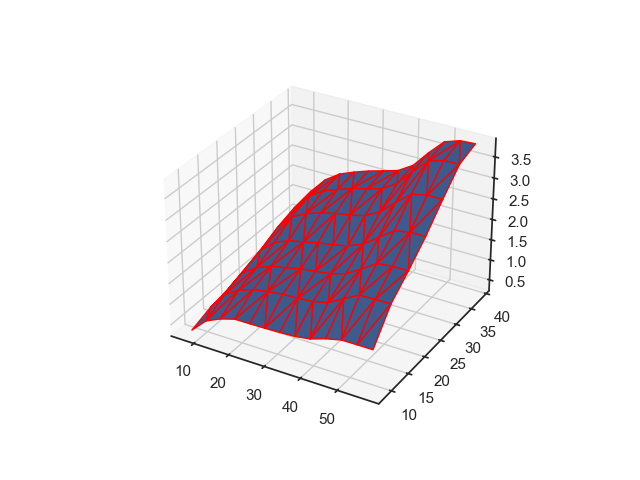

In [23]:
# создание эмпирической плотности
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(x.ravel(), y.ravel(),cdf.ravel(), edgecolor=(1,0,0,1))

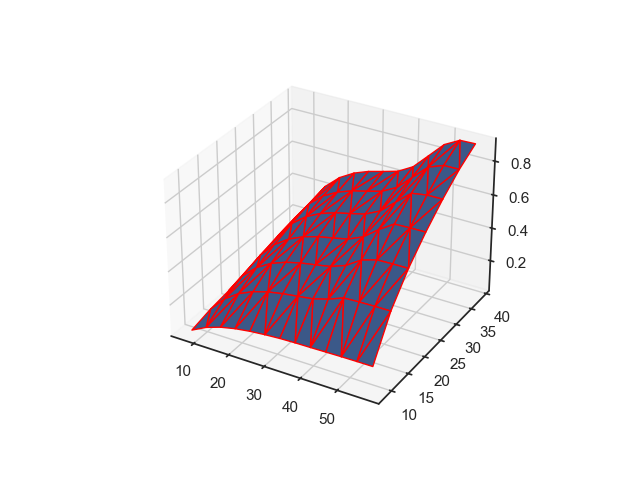

In [24]:
# Создание оригинальной плотности
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

f = lambda x: f1.cdf(x) *0.7 + f2.cdf(x)*0.3
f_2 = lambda x: f21.cdf(x) *0.7 + f22.cdf(x)*0.3

func = lambda x : CMO(f(x[0]), f_2(x[1]))

pair = np.array([x,y]).reshape(2,-1)
 

ax.plot_trisurf(x.ravel(), y.ravel(), func(pair),  edgecolor=(1,0,0,1))

In [25]:
# Сортируем данные по обоим измерениям
data_sorted = np.sort(pair.T, axis=0)


In [26]:
# Сортируем данные по обоим измерениям
data_sorted = np.sort(pair.T, axis=0)

# Вычисляем эмпирическую CDF (EDF) для двумерных данных
n = data_sorted.shape[0]
edf = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        edf[i, j] = np.mean((pair.T[:, 0] <= data_sorted[i, 0]) & (pair.T[:, 1] <= data_sorted[j, 1]) )

# Вычисляем теоретическую CDF в точках отсортированных данных
cdf = np.zeros_like(edf)
for i in range(n):
    for j in range(n):
        new_pair = data_sorted[i, 0], data_sorted[j, 1]
        cdf[i, j] = func(new_pair)

# Найдем максимальное различие между EDF и теоретической CDF
D = np.max(np.abs(edf - cdf))

print(f"Статистика Колмогорова-Смирнова для двумерного случая: {D}")


Статистика Колмогорова-Смирнова для двумерного случая: 0.2134814410155138


In [27]:
# Функция для вычисления двумерной статистики KS
def ks_2d(data):
    n = data.shape[0]
    data_sorted = np.sort(data, axis=0)


    def theoretical_cdf(x, y):
        return func([x, y])

    edf = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            edf[i, j] = np.mean((data[:, 0] <= data_sorted[i, 0]) & (data[:, 1] <= data_sorted[j, 1]))

    cdf = np.zeros_like(edf)
    for i in range(n):
        for j in range(n):
            cdf[i, j] = theoretical_cdf(data_sorted[i, 0], data_sorted[j, 1])

    D = np.max(np.abs(edf - cdf))
    return D

In [28]:
# Бутстреп
n_bootstrap = 100
bootstrap_D = np.zeros(n_bootstrap)

for i in range(n_bootstrap):
    bootstrap_sample = np.random.choice(pair.T.shape[0], size=pair.T.shape[0], replace=True)
    bootstrap_data = pair.T[bootstrap_sample]
    bootstrap_D[i] = ks_2d(bootstrap_data)

# Оценка p-value
p_value = np.mean(bootstrap_D >= D)
print(f"p-value: {p_value}")

KeyboardInterrupt: 

In [ ]:
alpha = 0.9
beta = 0.2

In [ ]:
3*alpha*beta/(2*alpha - alpha*beta+2*beta)

0.26732673267326734

In [ ]:
alpha*beta/(alpha - alpha*beta+beta)

0.19565217391304351

In [ ]:
from scipy.stats import spearmanr, kendalltau

# Коэффициент корреляции Спирмена
rho_s, _ = spearmanr(rvs_1, rvs_2)
print(f"Коэффициент корреляции Спирмена (ρ_S): {rho_s}")

# Коэффициент корреляции Кендалла
tau_k, _ = kendalltau(rvs_1, rvs_2)
print(f"Коэффициент корреляции Кендалла (τ_K): {tau_k}")


Коэффициент корреляции Спирмена (ρ_S): 0.21509731109731112
Коэффициент корреляции Кендалла (τ_K): 0.15034634634634633


In [ ]:

# Коэффициент верхней хвостовой зависимости
def upper_tail_dependence(x, y, q=0.95):
    u_quantile = np.quantile(x, q)
    v_quantile = np.quantile(y, q)
    n = len(x)
    count = np.sum((x > u_quantile) & (y > v_quantile))
    return count / n

lambda_u = upper_tail_dependence(rvs_1, rvs_2)
print(f"Коэффициент верхней хвостовой зависимости (λ_U): {lambda_u}")

Коэффициент верхней хвостовой зависимости (λ_U): 0.014
